In [33]:
#!/usr/bin/env python
# coding: utf-8

import cv2
import numpy as np
import os
import sys
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from PIL import Image
import nibabel as nib
import time
import copy
import torch
import cv2
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def create_paths(datapath):
    #     Create paths to all nested images
    imagepaths = []
    for root, dirs, files in os.walk(datapath, topdown=False):
        for name in files:
            imagepaths.append(os.path.join(root, name))
    return imagepaths

def get_label(imagepath, csvpath):
    #     Get the diagnosis label for path
    table = pd.read_csv(csvpath)
    idpath = imagepath.split('/')[13]
    img_id = idpath[idpath.find('_I') + 2:-4]
    group = table.loc[table['Image Data ID'] == int(
        img_id)]["Group"].reset_index(drop=True)[0]
    group_to_label = {'CN': 0, 'AD': 1, 'MCI': 2}
    label = group_to_label[group]
    return label

class ADNI(Dataset):
    def __init__(self, datapath, csvpath, labels = [0, 1, 2], transform=None):
        """
        Args:
            datapath (string): Directory with all the images.
            csvpath (string): Path to CSV. 
            labels (list): labels to retrieve. 'CN': 0, 'AD': 1, MCI': 2
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        all_imagepaths = create_paths(datapath)[:-1]
        self.csvpath = csvpath
        self.imagepaths = [path for path in tqdm(all_imagepaths) if get_label(path, csvpath) in labels] 
        self.transform = transform

    def __len__(self):
        #         Returns the length of the dataset
        return len(self.imagepaths)

    def __getitem__(self, idx):
        #         Returns a tuple of the image and its group/label
        imgsize = 64

        if torch.is_tensor(idx):
            idx = idx.tolist()
        imagepath = self.imagepaths[idx]
        label = get_label(imagepath, csvpath)

        
        #         create imgbatch with three different perspectives
        imgbatch = []
        
        imgdata = nib.load(imagepath).get_fdata()


        if self.transform:
            imgdata = self.transform(imgdata)
            
        imgdata1 = cv2.resize(imgdata[96, :, :], (imgsize, imgsize))
        imgdata1 = torch.from_numpy(imgdata1)
        imgdata1 = torch.stack([imgdata1, imgdata1, imgdata1], 0)
        imgbatch.append(imgdata1.reshape(3, imgsize, imgsize))
        
        imgdata2 = cv2.resize(imgdata[:, imgdata.shape[1]//2, :], (imgsize, imgsize))
        imgdata2 = torch.from_numpy(imgdata2)
        imgdata2 = torch.stack([imgdata2, imgdata2, imgdata2], 0)
        imgbatch.append(imgdata2.reshape(3, imgsize, imgsize))
        
        imgdata3 = cv2.resize(imgdata[:, :, imgdata.shape[2]//2], (imgsize, imgsize))
        imgdata3 = torch.from_numpy(imgdata3)
        imgdata3 = torch.stack([imgdata3, imgdata3, imgdata3], 0)
        imgbatch.append(imgdata3.reshape(3, imgsize, imgsize))
        
        sample = (imgbatch, torch.tensor(label))
        return sample


datapath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T"
csvpath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T_7_08_2020.csv"
dataset = ADNI(datapath, csvpath, labels = [0,1])


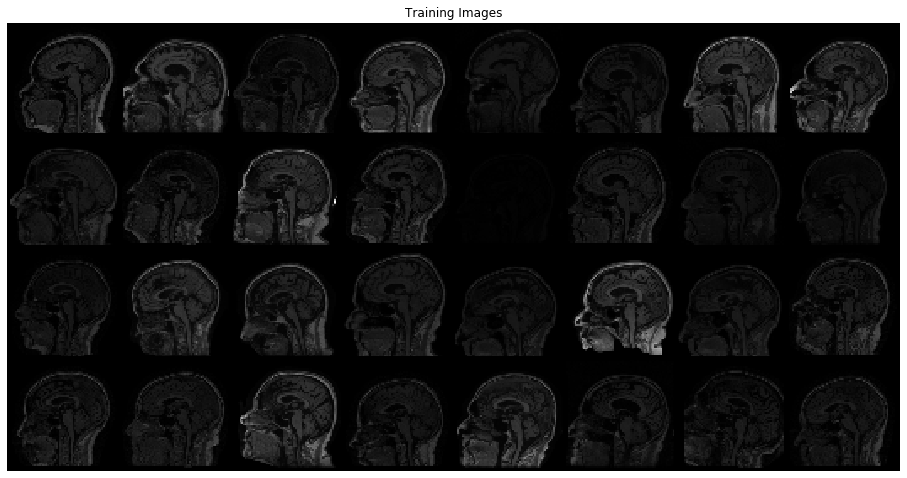

In [37]:
import torchvision
from torch.utils.data import Dataset, DataLoader
dataloader = DataLoader(dataset, batch_size=32,shuffle=True, num_workers=4)
batch = next(iter(dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(
    torchvision.utils.make_grid(batch[0][2], padding=2, normalize=True),(1,2,0)))
plt.show()

In [40]:
#!/usr/bin/env python
# coding: utf-8

import cv2
import numpy as np
import os
import sys
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from PIL import Image
import nibabel as nib
import time
import copy
from deepbrain import Extractor
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def create_paths(datapath):
    #     Create paths to all nested images
    imagepaths = []
    for root, dirs, files in os.walk(datapath, topdown=False):
        for name in files:
            imagepaths.append(os.path.join(root, name))
    return imagepaths

def get_label(imagepath, csvpath):
    #     Get the diagnosis label for path
    table = pd.read_csv(csvpath)
    idpath = imagepath.split('/')[13]
    img_id = idpath[idpath.find('_I') + 2:-4]
    group = table.loc[table['Image Data ID'] == int(
        img_id)]["Group"].reset_index(drop=True)[0]
    group_to_label = {'CN': 0, 'AD': 1, 'MCI': 2}
    label = group_to_label[group]
    return label

class ADNI(Dataset):
    def __init__(self, datapath, csvpath, labels = [0, 1, 2], transform=None):
        """
        Args:
            datapath (string): Directory with all the images.
            csvpath (string): Path to CSV. 
            labels (list): labels to retrieve. 'CN': 0, 'AD': 1, MCI': 2
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        all_imagepaths = create_paths(datapath)[:-1]
        self.csvpath = csvpath
        self.imagepaths = [path for path in tqdm(all_imagepaths) if get_label(path, csvpath) in labels] 
        self.transform = transform

    def __len__(self):
        #         Returns the length of the dataset
        return len(self.imagepaths)

    def __getitem__(self, idx):
        #         Returns a tuple of the image and its group/label
        imgsize = 64

        if torch.is_tensor(idx):
            idx = idx.tolist()
        imagepath = self.imagepaths[idx]
        label = get_label(imagepath, csvpath)

        
        #         create imgbatch with three different perspectives
        imgbatch = []
        
        imgdata = nib.load(imagepath).get_fdata()
        prob = Extractor().run(imgdata) 
        mask = prob > 0.5
        imgdata[~mask] = 0
        if self.transform:
            imgdata = self.transform(imgdata)
            
        imgdata1 = cv2.resize(imgdata[96, :, :], (imgsize, imgsize))
        imgdata1 = torch.from_numpy(imgdata1)
        imgdata1 = torch.stack([imgdata1, imgdata1, imgdata1], 0)
        imgbatch.append(imgdata1.reshape(3, imgsize, imgsize))
        
        imgdata2 = cv2.resize(imgdata[:, imgdata.shape[1]//2, :], (imgsize, imgsize))
        imgdata2 = torch.from_numpy(imgdata2)
        imgdata2 = torch.stack([imgdata2, imgdata2, imgdata2], 0)
        imgbatch.append(imgdata2.reshape(3, imgsize, imgsize))
        
        imgdata3 = cv2.resize(imgdata[:, :, imgdata.shape[2]//2], (imgsize, imgsize))
        imgdata3 = torch.from_numpy(imgdata3)
        imgdata3 = torch.stack([imgdata3, imgdata3, imgdata3], 0)
        imgbatch.append(imgdata3.reshape(3, imgsize, imgsize))
        
        sample = (imgbatch, torch.tensor(label))
        return sample


datapath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T"
csvpath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T_7_08_2020.csv"
dataset = ADNI(datapath, csvpath, labels = [0,1])

data = [sample for sample in tqdm(dataset)]
torch.save(data, '../../datasets/64skulldataset.pt')


/home/swang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/swang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/swang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/swang/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.


Instructions for updating:
Use tf.gfile.GFile.




In [41]:
#!/usr/bin/env python
# coding: utf-8

import cv2
import numpy as np
import os
import sys
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from PIL import Image
import nibabel as nib
import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def create_paths(datapath):
    #     Create paths to all nested images
    imagepaths = []
    for root, dirs, files in os.walk(datapath, topdown=False):
        for name in files:
            imagepaths.append(os.path.join(root, name))
    return imagepaths

def get_label(imagepath, csvpath):
    #     Get the diagnosis label for path
    table = pd.read_csv(csvpath)
    idpath = imagepath.split('/')[13]
    img_id = idpath[idpath.find('_I') + 2:-4]
    group = table.loc[table['Image Data ID'] == int(
        img_id)]["Group"].reset_index(drop=True)[0]
    group_to_label = {'CN': 0, 'AD': 1, 'MCI': 2}
    label = group_to_label[group]
    return label

class ADNI(Dataset):
    def __init__(self, datapath, csvpath, labels = [0, 1, 2], transform=None):
        """
        Args:
            datapath (string): Directory with all the images.
            csvpath (string): Path to CSV. 
            labels (list): labels to retrieve. 'CN': 0, 'AD': 1, MCI': 2
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        all_imagepaths = create_paths(datapath)[:-1]
        self.csvpath = csvpath
        self.imagepaths = [path for path in tqdm(all_imagepaths) if get_label(path, csvpath) in labels] 
        self.transform = transform

    def __len__(self):
        #         Returns the length of the dataset
        return len(self.imagepaths)

    def __getitem__(self, idx):
        #         Returns a tuple of the image and its group/label
        imgsize = 224

        if torch.is_tensor(idx):
            idx = idx.tolist()
        imagepath = self.imagepaths[idx]
        label = get_label(imagepath, csvpath)

        
        #         create imgbatch with three different perspectives
        imgbatch = []
        
        imgdata = nib.load(imagepath).get_fdata()

        if self.transform:
            imgdata = self.transform(imgdata)
            
        imgdata1 = cv2.resize(imgdata[96, :, :], (imgsize, imgsize))
        imgdata1 = torch.from_numpy(imgdata1)
        imgdata1 = torch.stack([imgdata1, imgdata1, imgdata1], 0)
        imgbatch.append(imgdata1.reshape(3, imgsize, imgsize))
        
        imgdata2 = cv2.resize(imgdata[:, imgdata.shape[1]//2, :], (imgsize, imgsize))
        imgdata2 = torch.from_numpy(imgdata2)
        imgdata2 = torch.stack([imgdata2, imgdata2, imgdata2], 0)
        imgbatch.append(imgdata2.reshape(3, imgsize, imgsize))
        
        imgdata3 = cv2.resize(imgdata[:, :, imgdata.shape[2]//2], (imgsize, imgsize))
        imgdata3 = torch.from_numpy(imgdata3)
        imgdata3 = torch.stack([imgdata3, imgdata3, imgdata3], 0)
        imgbatch.append(imgdata3.reshape(3, imgsize, imgsize))
        
        sample = (imgbatch, torch.tensor(label))
        return sample


datapath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T"
csvpath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T_7_08_2020.csv"
dataset = ADNI(datapath, csvpath, labels = [0,1])

data = [sample for sample in tqdm(dataset)]
torch.save(data, '../../datasets/224dataset.pt')